In [1]:
import os
import numpy as np
import torch
import pandas as pd
from datasets import Dataset, DatasetDict, concatenate_datasets
from sklearn.utils.class_weight import compute_class_weight
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    pipeline
)

In [2]:
# Define model and tokenizer
model_name = "distilbert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Path to save the tokenized dataset
tokenized_dataset_path = "../results/tokenized_dataset"
new_ds_path = "../results/new_ds"


# Load new_ds DatasetDict if it exists
if os.path.exists(new_ds_path):
    print("Loading DatasetDict (new_ds) from disk...")
    new_ds = DatasetDict.load_from_disk(new_ds_path)
else:
    raise FileNotFoundError(f"DatasetDict not found at {new_ds_path}. Please save it from the other notebook.")

# Check if tokenized dataset exists
if os.path.exists(tokenized_dataset_path):
    print("Loading tokenized dataset from disk...")
    tokenized_ds = DatasetDict.load_from_disk(tokenized_dataset_path)
else:
    print("Tokenizing dataset...")
    def tokenize_function(examples):
        return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=256)
    tokenized_ds = new_ds.map(tokenize_function, batched=True)
    tokenized_ds.save_to_disk(tokenized_dataset_path)

Loading DatasetDict (new_ds) from disk...
Loading tokenized dataset from disk...


In [3]:
print("Size of original dataset (new_ds):", len(new_ds["train"]))

Size of original dataset (new_ds): 650000


In [4]:
# Check size and sample rows of the tokenized dataset
print("Size of tokenized dataset before augmentation:", len(tokenized_ds["train"]))
print("Sample rows from tokenized dataset:")
print(tokenized_ds["train"][:5])

Size of tokenized dataset before augmentation: 650000
Sample rows from tokenized dataset:
{'labels': tensor([4, 1, 3, 3, 0]), 'input_ids': tensor([[  101,   173,  1197,  ...,     0,     0,     0],
        [  101,  7595,   117,  ...,     0,     0,     0],
        [  101, 18511,  1280,  ...,     0,     0,     0],
        [  101,  7348,   170,  ...,     0,     0,     0],
        [  101,   146,  1274,  ...,  1948,   119,   102]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]])}


In [5]:
# Perform Data Augmentation for underrepresented classes
print("Performing data augmentation for underrepresented classes...")
paraphraser = pipeline("text2text-generation", model="t5-base", tokenizer="t5-base")
augmented_texts = []
for i in range(100):  
    text = new_ds["train"]["text"][i]  
    label = new_ds["train"]["labels"][i]  
    if label in [1, 2, 3]:  
        paraphrased = paraphraser(f"paraphrase: {text}", max_length=256, num_return_sequences=1)
        augmented_texts.append({"text": paraphrased[0]["generated_text"], "labels": label})

Performing data augmentation for underrepresented classes...


Device set to use cpu


In [6]:
# Add augmented examples to the dataset
augmented_ds = Dataset.from_pandas(pd.DataFrame(augmented_texts))

# Tokenization function
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=256)

tokenized_augmented_ds = augmented_ds.map(tokenize_function, batched=True)

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

In [7]:
print("Size of augmented dataset:", len(tokenized_augmented_ds))
print("Sample rows from augmented dataset:")
print(tokenized_augmented_ds[:5])

Size of augmented dataset: 50
Sample rows from augmented dataset:
{'text': ['True', 'True', 'nnI think finding a new doctor in NYC that you actually like might almost be as awful as trying to find a date!', 'False', 'True'], 'labels': [1, 3, 3, 1, 2], 'input_ids': [[101, 7817, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [8]:
# Combine augmented data with the original training data
print("Combining datasets...")
tokenized_ds["train"] = concatenate_datasets([tokenized_ds["train"], tokenized_augmented_ds])

Combining datasets...


In [9]:
print("Size of training dataset after concatenation:", len(tokenized_ds["train"]))
print("Sample rows from concatenated training dataset:")
print(tokenized_ds["train"][:5])

Size of training dataset after concatenation: 650050
Sample rows from concatenated training dataset:
{'labels': [4, 1, 3, 3, 0], 'input_ids': [[101, 173, 1197, 119, 2284, 2953, 3272, 1917, 178, 1440, 1111, 1107, 170, 1704, 22351, 119, 1119, 112, 188, 3505, 1105, 3123, 1106, 2037, 1106, 1443, 1217, 10063, 4404, 132, 1119, 112, 188, 1579, 1113, 1159, 1107, 3195, 1117, 4420, 132, 1119, 112, 188, 6559, 1114, 170, 1499, 118, 23555, 2704, 113, 183, 9379, 114, 1134, 1139, 2153, 1138, 3716, 1106, 1143, 1110, 1304, 1696, 1107, 1692, 1380, 5940, 1105, 1128, 1444, 6059, 132, 1105, 1128, 1169, 1243, 5991, 16179, 1106, 1267, 18137, 1443, 1515, 1106, 1267, 1140, 1148, 119, 1541, 117, 1184, 1167, 1202, 1128, 1444, 136, 178, 112, 182, 2807, 1303, 1774, 1106, 1341, 1104, 1251, 11344, 178, 1138, 1164, 1140, 117, 1133, 178, 112, 182, 1541, 4619, 170, 9153, 119, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [10]:
print("Columns in training dataset after concatenation:", tokenized_ds["train"].column_names)


Columns in training dataset after concatenation: ['labels', 'input_ids', 'attention_mask', 'text']


In [11]:
print("Removing unnecessary 'text' column...")
tokenized_ds["train"] = tokenized_ds["train"].remove_columns("text")

Removing unnecessary 'text' column...


In [12]:
# Ensure dataset format
print("Setting dataset format...")
tokenized_ds["train"].set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

Setting dataset format...


In [13]:
# Validate labels in the training dataset
print("Validating labels in the training dataset...")

# Check the dataset size
print("Training dataset size:", len(tokenized_ds["train"]))

# Convert labels to a numpy array
true_labels = np.array(tokenized_ds["train"]["labels"])  
print("First 10 labels in true_labels:", true_labels[:10]) 

# Check for invalid labels
invalid_labels = [label for label in true_labels if not isinstance(label, (int, np.integer))]
print(f"Number of invalid labels found: {len(invalid_labels)}")
if invalid_labels:
    print("Invalid labels found:", invalid_labels)

# Check unique classes
unique_classes = np.unique(true_labels)
print("Unique classes in true_labels:", unique_classes)

Validating labels in the training dataset...
Training dataset size: 650050
First 10 labels in true_labels: [4 1 3 3 0 4 4 0 1 2]
Number of invalid labels found: 0
Unique classes in true_labels: [0 1 2 3 4]


/tmp/ipykernel_27942/3091386202.py:8: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  true_labels = np.array(tokenized_ds["train"]["labels"])


In [14]:
# Compute class weights
print("Computing class weights...")
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=unique_classes,
    y=true_labels
)

Computing class weights...


In [15]:
# Convert class weights to PyTorch tensor
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)
# Convert class weights tensor to a list
class_weights_list = class_weights_tensor.tolist()
print("Class weights:", class_weights_tensor)

Class weights: tensor([1.0001, 0.9999, 1.0000, 0.9999, 1.0001])


In [16]:
# Training Arguments
print("Setting up training arguments...")
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2.7453151590160654e-05,  # Best hyperparameter
    per_device_train_batch_size=8,         # Best hyperparameter
    num_train_epochs=2,                    # Best hyperparameter
    weight_decay=0.026147972761883034,     # Best hyperparameter
    gradient_accumulation_steps=4,
    fp16=True,
    logging_dir="./logs",
    logging_steps=10,
    save_total_limit=2
)

Setting up training arguments...


ImportError: Using the `Trainer` with `PyTorch` requires `accelerate>=0.26.0`: Please run `pip install transformers[torch]` or `pip install 'accelerate>={ACCELERATE_MIN_VERSION}'`

In [ ]:
def model_init():
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=5)
    model.config.class_weights = class_weights_list  
    return model

In [18]:


# Initialize the Trainer
trainer = Trainer(
    model=model_init(),
    args=training_args,
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["test"],
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
print("Size of training dataset:", len(tokenized_ds["train"]))

Size of training dataset: 650050


In [20]:

# Train the model with augmented data and class weights
print("Starting model training...")
trainer.train()

# Evaluate the model
results = trainer.evaluate()
print("Final Evaluation Results:", results)


Starting model training...


  0%|          | 0/40628 [00:00<?, ?it/s]

{'loss': 6.4184, 'grad_norm': 7.116311550140381, 'learning_rate': 2.7446394390300912e-05, 'epoch': 0.0}
{'loss': 6.2281, 'grad_norm': 8.1716890335083, 'learning_rate': 2.743963719044117e-05, 'epoch': 0.0}
{'loss': 5.8591, 'grad_norm': 17.697690963745117, 'learning_rate': 2.743287999058143e-05, 'epoch': 0.0}
{'loss': 5.3761, 'grad_norm': 14.909335136413574, 'learning_rate': 2.7426798510707658e-05, 'epoch': 0.0}
{'loss': 4.9023, 'grad_norm': 27.690937042236328, 'learning_rate': 2.7420717030833893e-05, 'epoch': 0.0}
{'loss': 4.6812, 'grad_norm': 22.101341247558594, 'learning_rate': 2.7413959830974148e-05, 'epoch': 0.0}
{'loss': 4.6171, 'grad_norm': 29.440954208374023, 'learning_rate': 2.7407202631114406e-05, 'epoch': 0.0}
{'loss': 4.5998, 'grad_norm': 28.10511589050293, 'learning_rate': 2.7400445431254664e-05, 'epoch': 0.0}
{'loss': 4.5701, 'grad_norm': 25.467453002929688, 'learning_rate': 2.7393688231394923e-05, 'epoch': 0.0}
{'loss': 4.613, 'grad_norm': 25.722320556640625, 'learning_rat

  0%|          | 0/6250 [00:00<?, ?it/s]

{'eval_loss': 0.744957447052002, 'eval_runtime': 35.4918, 'eval_samples_per_second': 1408.776, 'eval_steps_per_second': 176.097, 'epoch': 1.0}
{'loss': 2.8964, 'grad_norm': 23.869091033935547, 'learning_rate': 1.3729954395010198e-05, 'epoch': 1.0}
{'loss': 2.6755, 'grad_norm': 13.546308517456055, 'learning_rate': 1.3723197195150456e-05, 'epoch': 1.0}
{'loss': 2.5318, 'grad_norm': 24.741382598876953, 'learning_rate': 1.3716439995290714e-05, 'epoch': 1.0}
{'loss': 2.8186, 'grad_norm': 20.377552032470703, 'learning_rate': 1.3709682795430973e-05, 'epoch': 1.0}
{'loss': 2.8093, 'grad_norm': 22.12740707397461, 'learning_rate': 1.370292559557123e-05, 'epoch': 1.0}
{'loss': 2.8647, 'grad_norm': 21.56228256225586, 'learning_rate': 1.3696168395711487e-05, 'epoch': 1.0}
{'loss': 2.6683, 'grad_norm': 14.9447603225708, 'learning_rate': 1.3689411195851744e-05, 'epoch': 1.0}
{'loss': 2.8855, 'grad_norm': 22.600122451782227, 'learning_rate': 1.3682653995992002e-05, 'epoch': 1.0}
{'loss': 2.8702, 'grad

  0%|          | 0/6250 [00:00<?, ?it/s]

{'eval_loss': 0.738455057144165, 'eval_runtime': 37.5724, 'eval_samples_per_second': 1330.763, 'eval_steps_per_second': 166.345, 'epoch': 2.0}
{'train_runtime': 3309.806, 'train_samples_per_second': 392.802, 'train_steps_per_second': 12.275, 'train_loss': 2.993230181039876, 'epoch': 2.0}


  0%|          | 0/6250 [00:00<?, ?it/s]

Final Evaluation Results: {'eval_loss': 0.738455057144165, 'eval_runtime': 38.1393, 'eval_samples_per_second': 1310.984, 'eval_steps_per_second': 163.873, 'epoch': 1.99993846683978}


In [21]:
predictions = trainer.predict(tokenized_ds["test"])
print(predictions.metrics)

  0%|          | 0/6250 [00:00<?, ?it/s]

{'test_loss': 0.738455057144165, 'test_runtime': 38.6066, 'test_samples_per_second': 1295.115, 'test_steps_per_second': 161.889}


In [22]:
from sklearn.metrics import classification_report
import numpy as np

# Extract predictions and true labels
predictions = trainer.predict(tokenized_ds["test"])
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

# Generate classification report
print(classification_report(y_true, y_pred, target_names=["Class 0", "Class 1", "Class 2", "Class 3", "Class 4"]))


  0%|          | 0/6250 [00:00<?, ?it/s]

              precision    recall  f1-score   support

     Class 0       0.78      0.80      0.79     10000
     Class 1       0.62      0.63      0.63     10000
     Class 2       0.64      0.60      0.62     10000
     Class 3       0.60      0.60      0.60     10000
     Class 4       0.75      0.76      0.75     10000

    accuracy                           0.68     50000
   macro avg       0.68      0.68      0.68     50000
weighted avg       0.68      0.68      0.68     50000



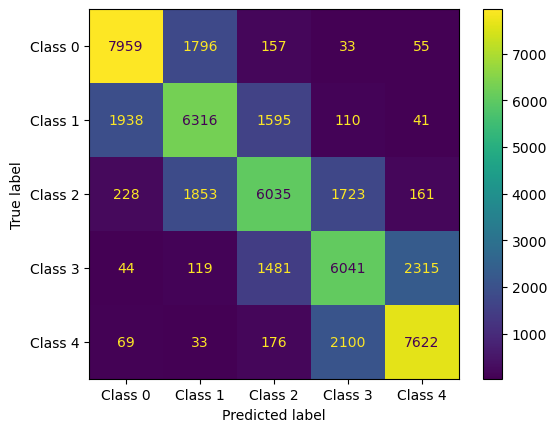

In [23]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm, display_labels=["Class 0", "Class 1", "Class 2", "Class 3", "Class 4"]).plot()

In [25]:
probs = torch.nn.functional.softmax(torch.tensor(predictions.predictions), dim=1)
print("Before scaling, sample probabilities:", probs[:5])

Before scaling, sample probabilities: tensor([[9.9291e-01, 6.4820e-03, 3.1597e-04, 9.0705e-05, 2.0361e-04],
        [9.5585e-01, 4.2368e-02, 1.6173e-03, 1.0209e-04, 6.2894e-05],
        [9.4129e-01, 5.8209e-02, 4.5944e-04, 2.9833e-05, 1.3447e-05],
        [8.6176e-01, 1.3688e-01, 1.3147e-03, 2.9997e-05, 1.0246e-05],
        [9.1825e-01, 8.1182e-02, 5.0886e-04, 3.1345e-05, 2.6603e-05]])


In [27]:
def apply_temperature_scaling(logits, temperature):
	return logits / temperature

scaled_logits = apply_temperature_scaling(predictions.predictions, temperature=2.0)
scaled_probs = torch.nn.functional.softmax(torch.tensor(scaled_logits), dim=1)
print("After scaling, sample probabilities:", scaled_probs[:5])

After scaling, sample probabilities: tensor([[0.8909, 0.0720, 0.0159, 0.0085, 0.0128],
        [0.7873, 0.1658, 0.0324, 0.0081, 0.0064],
        [0.7811, 0.1943, 0.0173, 0.0044, 0.0030],
        [0.6911, 0.2754, 0.0270, 0.0041, 0.0024],
        [0.7507, 0.2232, 0.0177, 0.0044, 0.0040]])
